# CS Project: Algorithm walkthrough

## The graph algorithm

As mentioned in the presentation, the two QBE algorithms here can be broke down into two stages: **segmentation** and **querying**. First lets look at the graph-based algorithm. The **segmentation** phase can be described as follows:

1. Split each piece into segments; each segment should represent a musical phrase as a listener would hear it
2. Create new segments by “reducing” older segments, removing the least relevant notes to the music
3. Create a graph, with nodes being the segments, and edges representing reductions

### Segmentation (move this out of this notebook!)

This is achieved through the **LBDM** algorithm. Given an input MIDI file, the LBDM produces a *boundary strength* profile. The idea is that boundaries (place where a listener would percieve a different musical phrase) occur at places in the music where the change in pitch and note length are significantly different to the boundaries around it.

#### Setup

We will use the *music21* library to display the music, but the *mido* library is actually used within the algorithm to  read and analyse the music

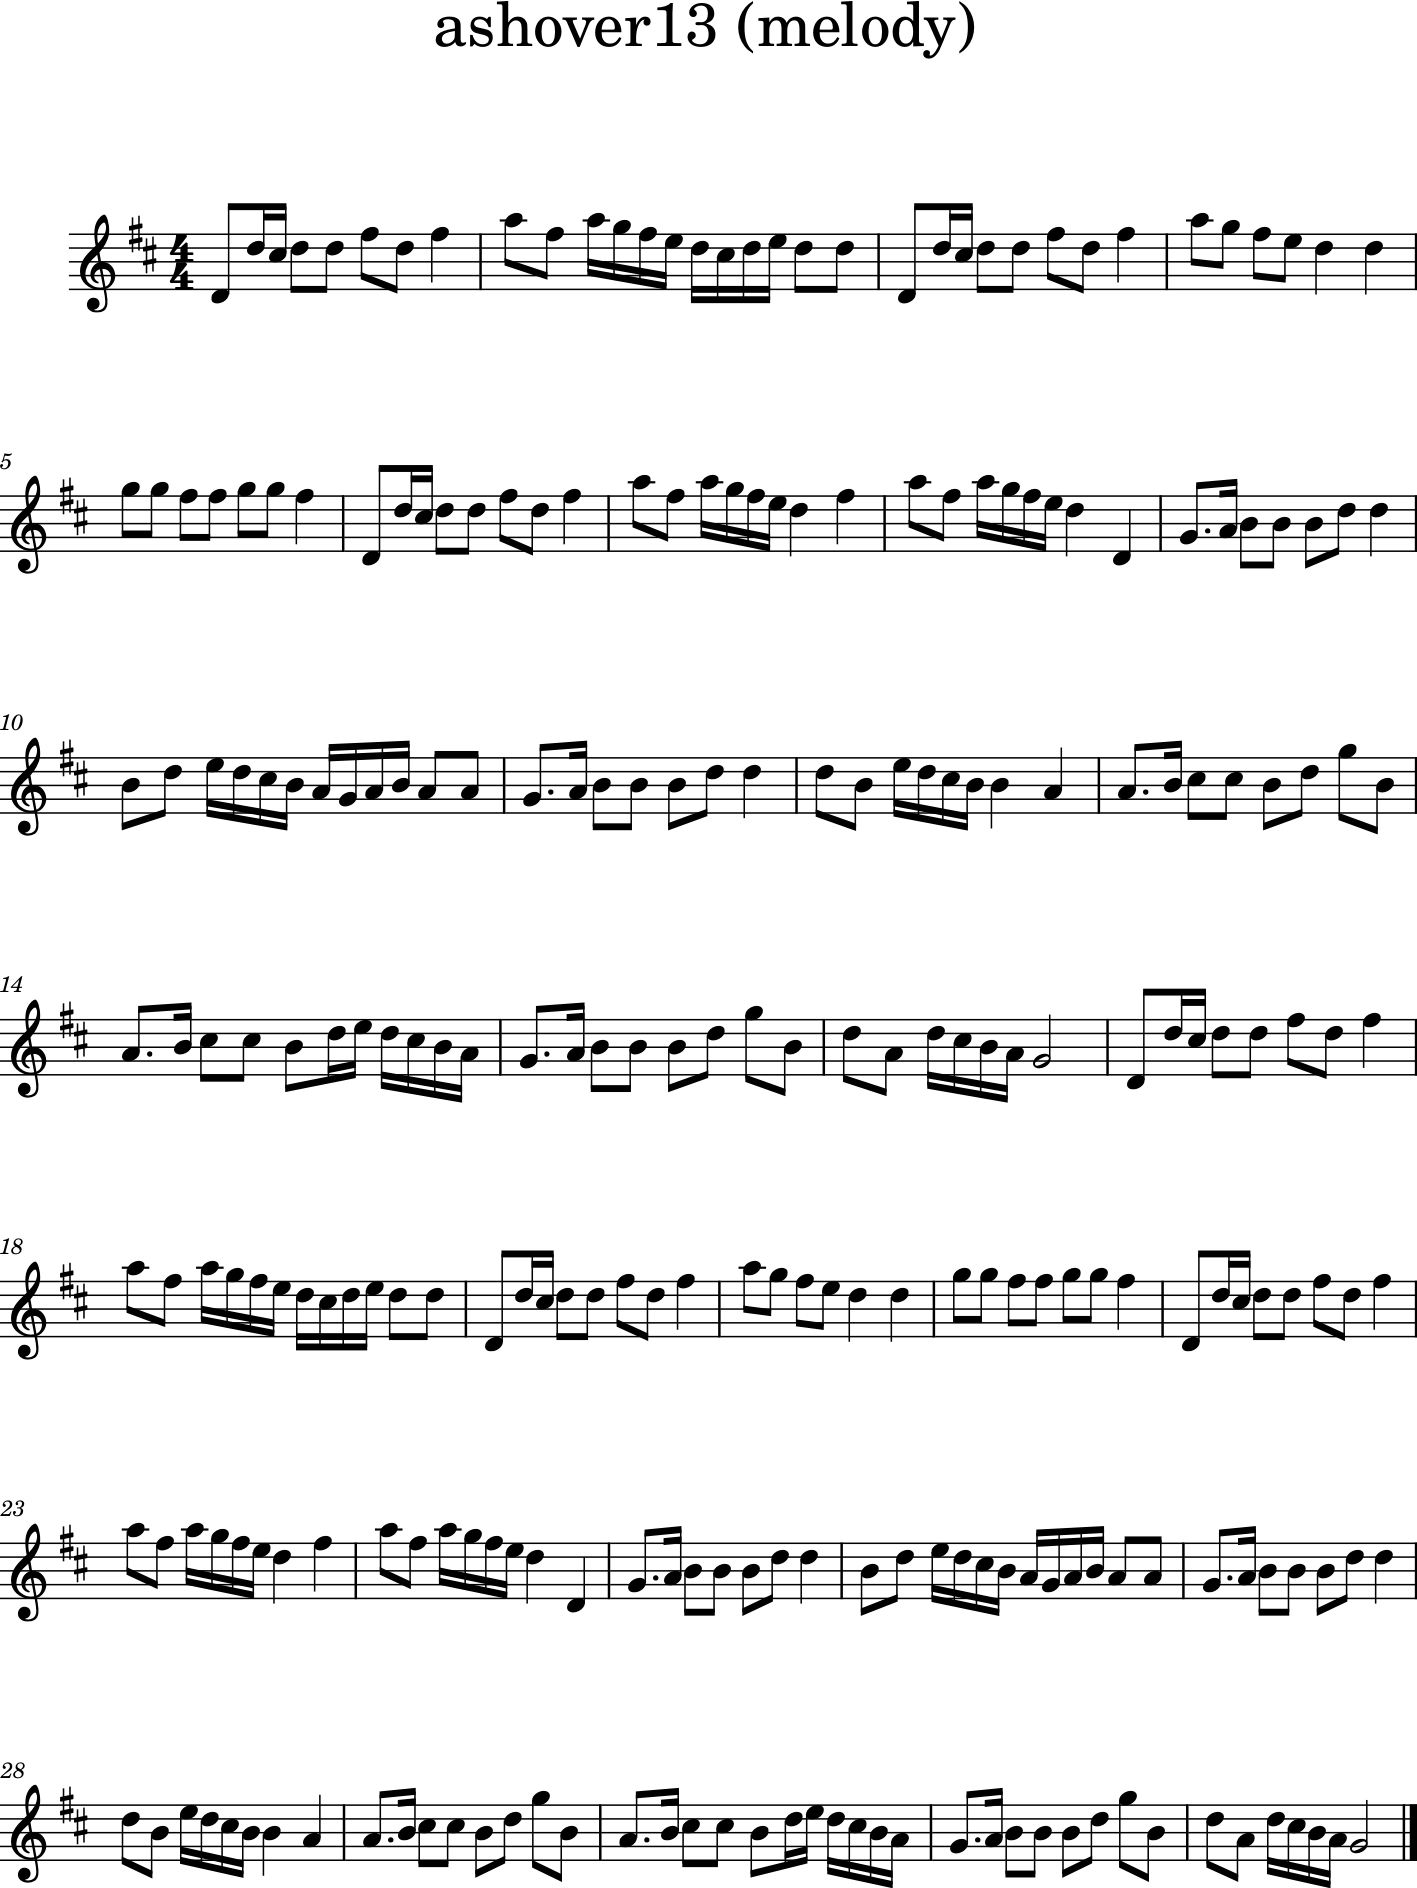

In [9]:
import music21 
%reload_ext music21.ipython21.ipExtension
import project.visualisation.graph as graph


show_mid = music21.converter.parse("mid/nottingham/melody/ashover13.mid")
show_mid.insert(0, music21.metadata.Metadata())
show_mid.metadata.title = 'ashover13 (melody)'
show_mid.show()

#### Example Output

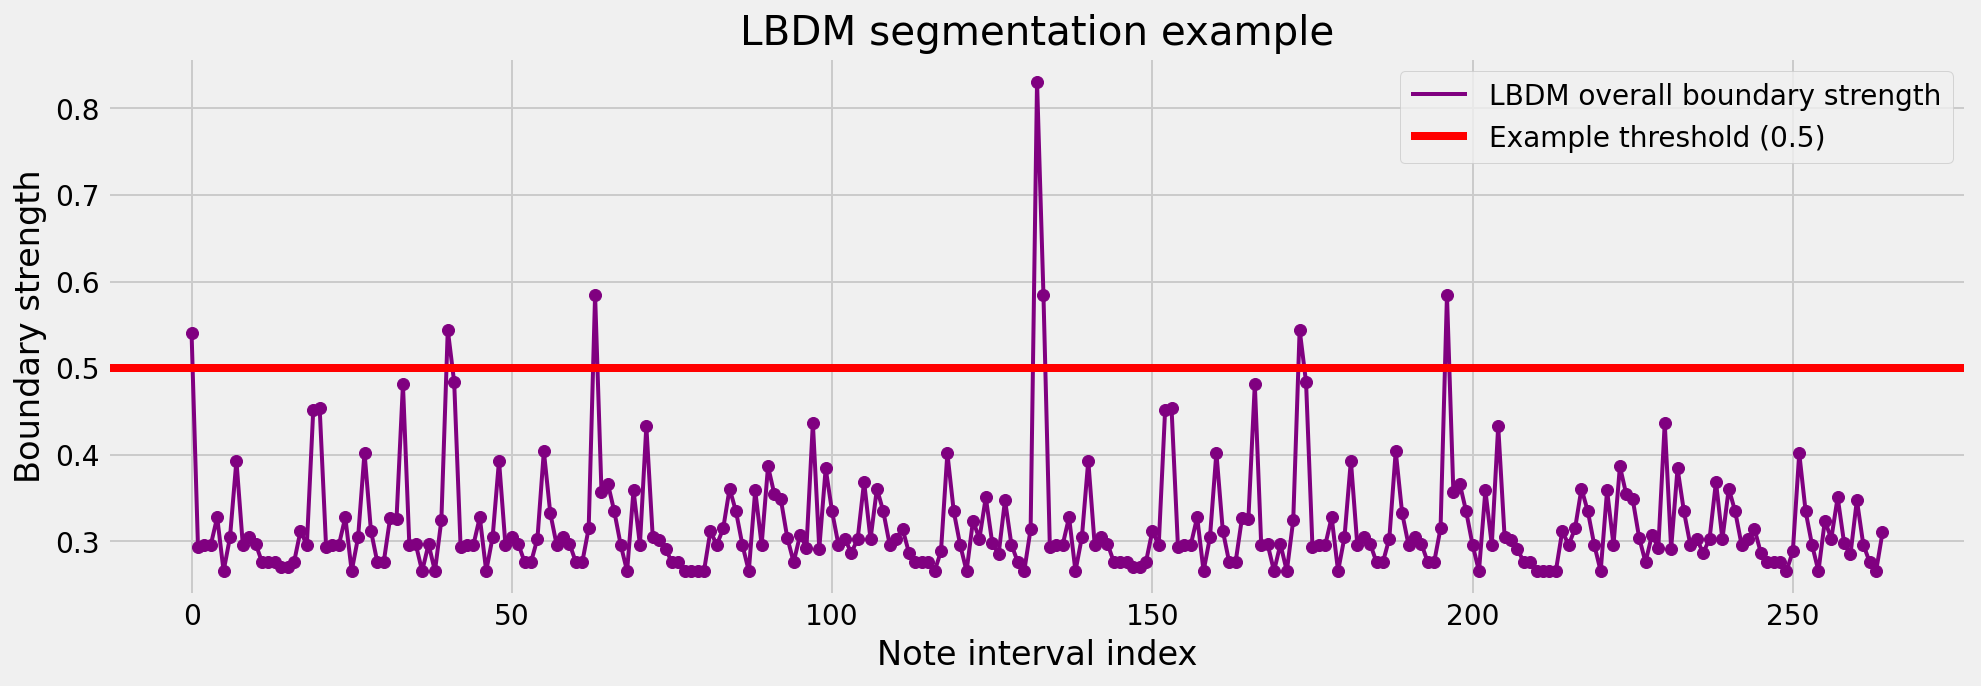

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

from mido import MidiFile, MidiTrack 
example_mid = MidiFile("mid/nottingham/melody/ashover13.mid") # for processing
melody_track = example_mid.tracks[0]

# formatting
plt.rcParams['figure.figsize'] = [14, 5]
graph.lbdm_graph(example_mid.tracks[0],example_mid.ticks_per_beat)

We can use this series of points to find boundaries in the music. The **segmenter** class creates segments from an input MIDI file. The **LbdmSegmenter** class does this by getting the boundary profile by running the LBDM algorithm, and then splitting the input file at points where the *boundary strength* is above a threshold (in this case 0.5)

In [11]:
from project.algorithms.graph_based.lbdm_segmenter import LbdmSegmenter

segmenter = LbdmSegmenter(threshold=0.5)
segments = segmenter.create_segments(example_mid,0)
for i, segment in enumerate(segments):
    segment.save_as_midi(f"mid/demo/ashover13_{i}.mid")

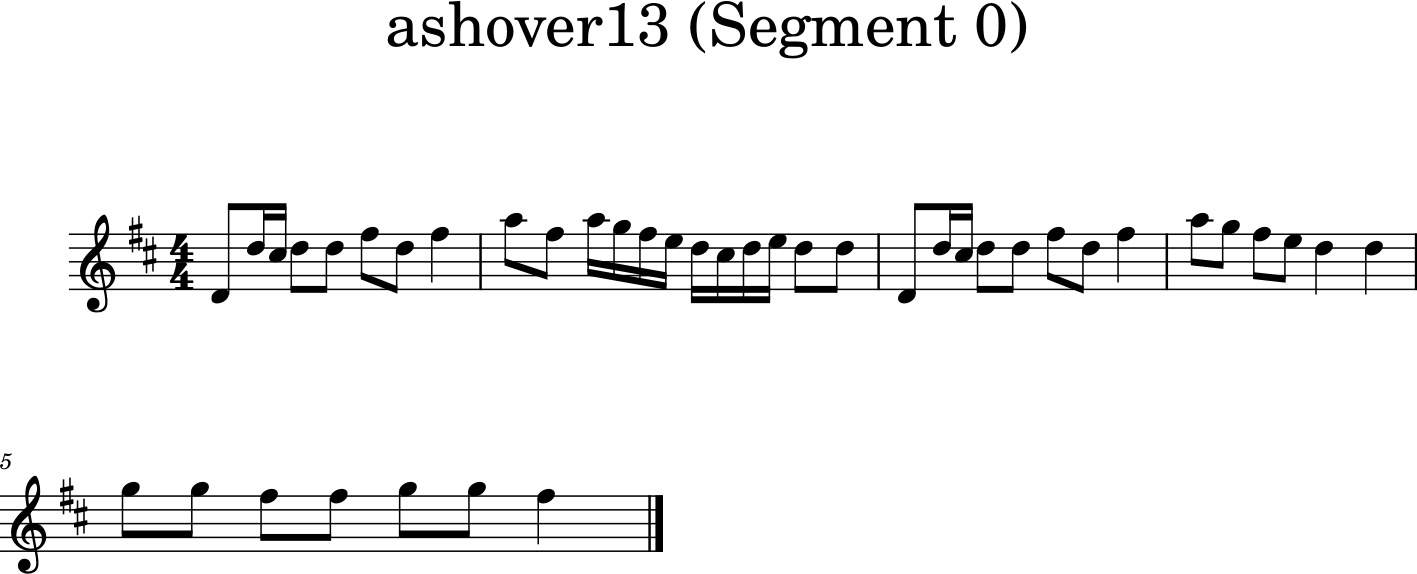

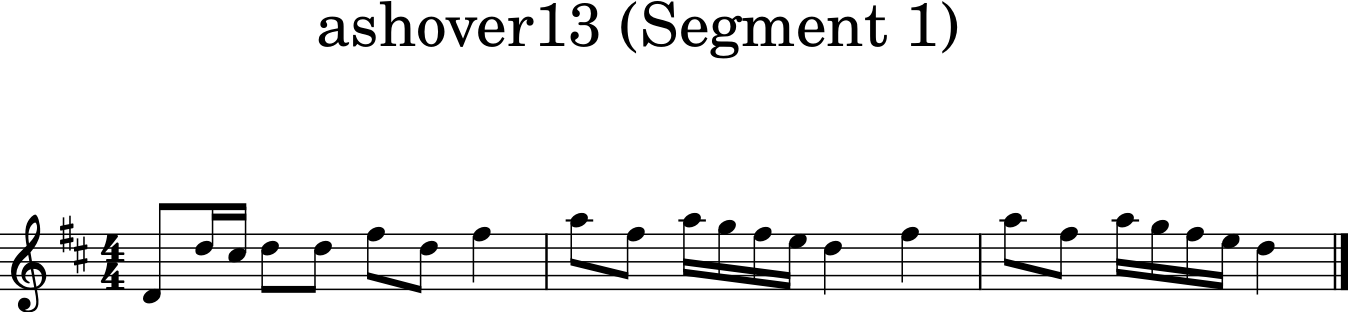

In [18]:
segment_mid_0 = music21.converter.parse(f"mid/demo/ashover13_0.mid")
segment_mid_0.insert(0, music21.metadata.Metadata())
segment_mid_0.metadata.title = 'ashover13 (Segment 0)'
segment_mid_0.show()

segment_mid_1 = music21.converter.parse(f"mid/demo/ashover13_1.mid")
segment_mid_1.insert(0, music21.metadata.Metadata())
segment_mid_1.metadata.title = 'ashover13 (Segment 1)'
segment_mid_1.show()
    

## Reduction

The next phase of the algorithm is *reduction*. This process simplifies each segment by deleting the least **relevant** notes from them. This process is repeated until each segment only has one note.

### Example

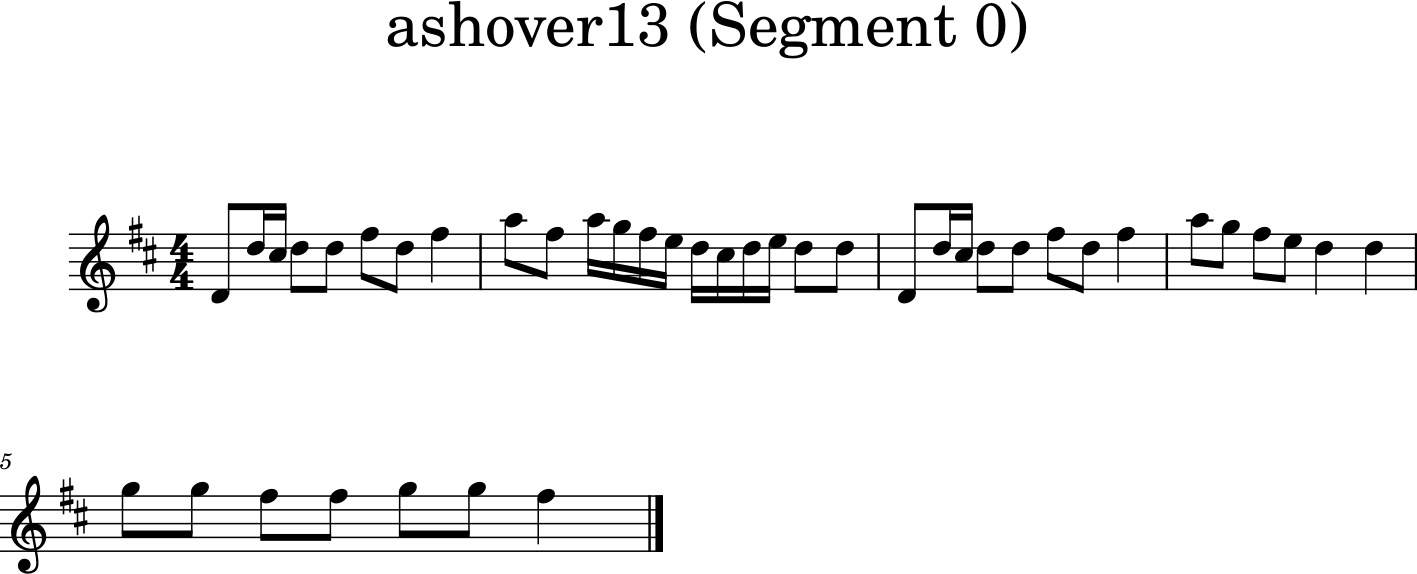

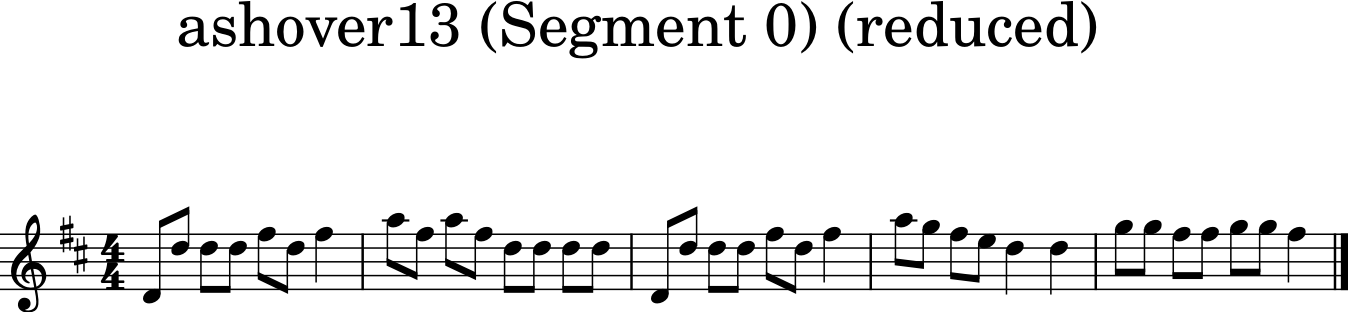

In [23]:
ashover13_segment_0 = segments[0]

weight, ashover13_segment_0_reduced = ashover13_segment_0.reduce_segment()

ashover13_segment_0_reduced.save_as_midi("mid/demo/ashover13_reduction_1.mid")

red_mid = music21.converter.parse("mid/demo/ashover13_reduction_1.mid")
red_mid.insert(0, music21.metadata.Metadata())
red_mid.metadata.title = 'ashover13 (Segment 0) (reduced)'

segment_mid_0.show()
red_mid.show()

As mentioned above, this process goes on until there's only one note left in the segment.

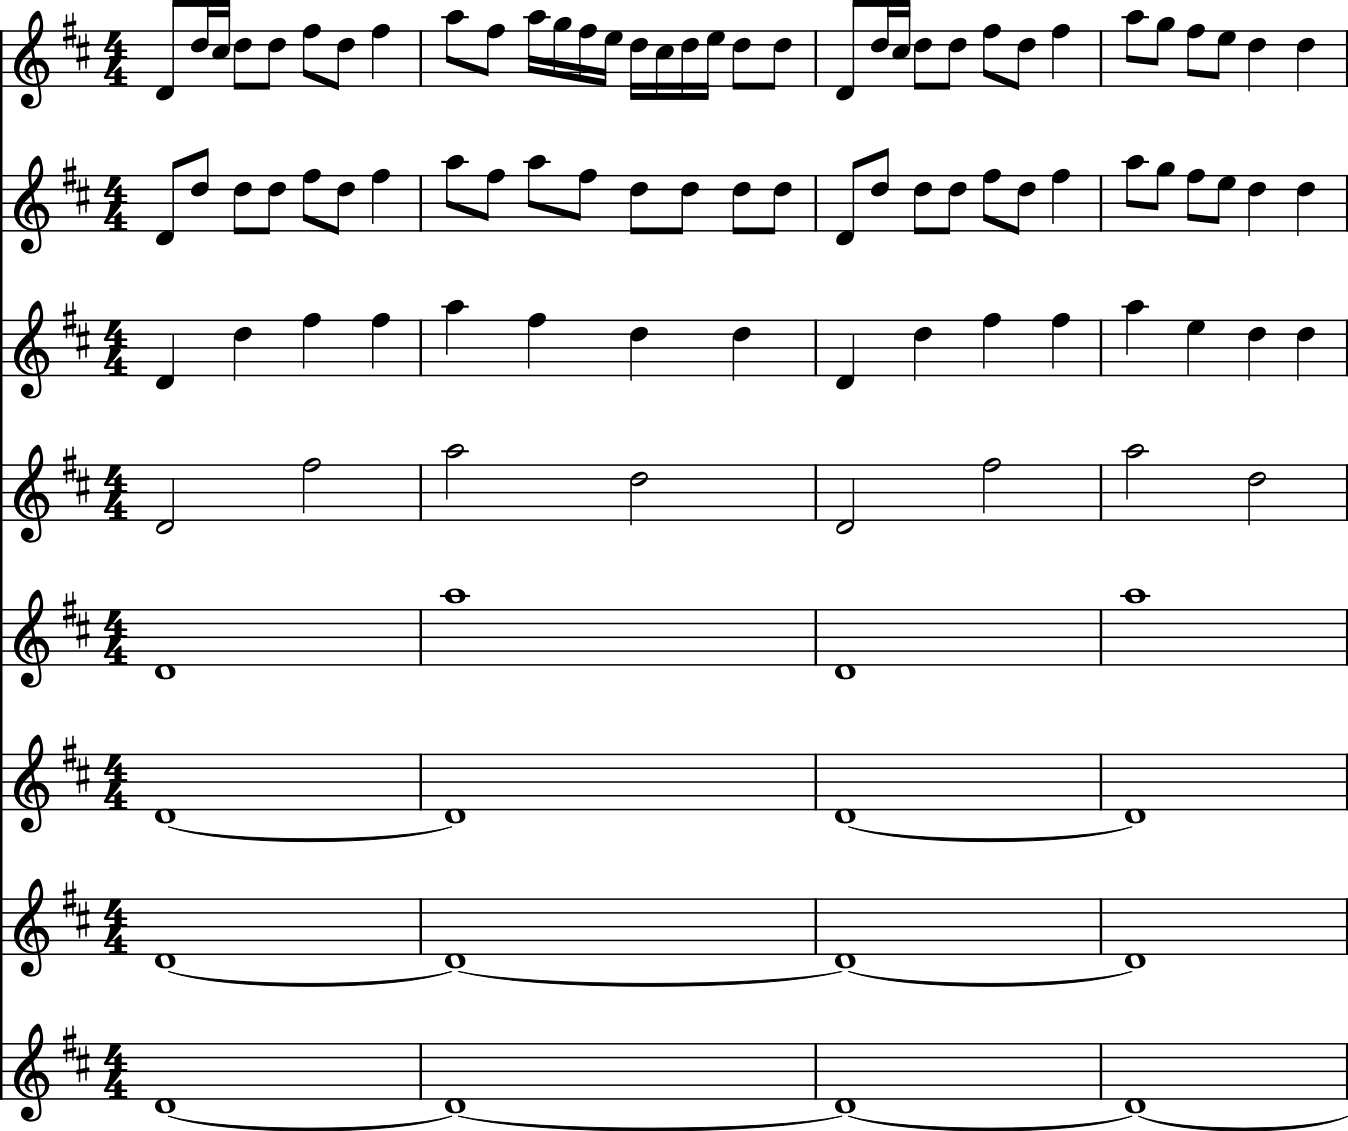

In [25]:
full_reduction = music21.converter.parse("mid/generated/graph/nottingham_graph_chord_combined/ashover13/combined_segment_0.mid")
full_reduction.show()